<a href="https://colab.research.google.com/github/luke-scot/s4-thermal/blob/main/drone_image_stitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drone image stitching

This notebook outputs stitched thermal imagery data from an input of a folder of thermal images and a flight path .csv file. This was developped for Super-Sharp Space Systems Ltd during an internship funded by the UK Space Agency. Please direct any queries to Luke Cullen: lshc3@cam.ac.uk.



### Setup
To get started we first need to make sure we have some thermal data to use, and second we need to clone the Github repository and add some packages to Colab to run the notebook properly.

#### RGB to temperature conversion using FLIR Image Extractor
Here are the steps required to convert the images captured by a thermal camera stored in RGB format to a thermal format containing the temperature values for each pixel. 


Unfortunately this process cannot be done in a jupyterlab environment due to the installation of FLIR, however the steps are straightforward and accessible by any regular PC. You can run the whole directory of images from a single flight as a batch conversion through the flir-image-extractor CLI. Follow https://github.com/nationaldronesau/FlirImageExtractor for details but here is the low down for Windows machines.

##### FLIR installation
1. To install exiftool on Windows for use in this CLI, download the exiftool windows executable from [here](https://exiftool.org/install.html). Extract exiftool(-k).exe and rename to exiftool.exe. Copy this executable to ```C:\Windows``` on your computer. You will need admin permissions to do this. Doing this will make exiftool available to the CLI.

2. Run from the command line: ```python -m pip install flir-image-extractor-cli```

##### Image conversion

3. Run from the command line: ```flir-image-extractor-cli```

4. Pop the directory path in and answer the few questions. Recommended inputs are:
*   Path - Use relative path to image directory
*   Type - gnuplot_2 (we will preferably use the .npy output)
*   Metadata - Yes
*   Range - Infer

This will take a few minutes so go make a coffee to be ready for converting these to a stitched image!




#### Required colab imports

In [1]:
# Clone repo
! git clone https://github.com/luke-scot/s4-thermal.git
%cd /content/s4-thermal
# Install packages
%pip install pyproj imutils opencv-python simplekml palettable gdown
%pip install --upgrade -q pyproj plotly
# Import packages
import os
import cv2
import glob
import gdown
import imageio
import imutils
import numpy as np
import pandas as pd
import ipywidgets as ipw
import plotly.express as px
import matplotlib.pyplot as plt
# Import functions
from PIL import Image
from tqdm import tqdm
from pyproj import Proj
from scipy import ndimage
from datetime import datetime
from itertools import compress
from collections import Counter
from palettable import colorbrewer
from scipy.interpolate import griddata
from skimage.measure import block_reduce
# Custom functions
import plotting as pl
import stitching as st
import helper_functions as hf

cv2.ocl.setUseOpenCL(False)

Cloning into 's4-thermal'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 211 (delta 29), reused 21 (delta 9), pack-reused 154
Receiving objects: 100% (211/211), 144.16 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/s4-thermal
     |████████████████████████████████| 6.6 MB 8.0 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 21.8 MB 61.7 MB/s 


### 1 - Import data
For this notebook we need to import single valued thermal data (i.e. one value associated with temperature for each pixel). If stored in the google drive these can be directly imported by copying the link to the cell below. We also need the flight path for the drone flight.

In [2]:
## Variable inputs
# File paths
gdrive, link = True, 'https://drive.google.com/file/d/1ChiIXmrvowHOCw6dRv-tlpX906fTmqYo/view?usp=sharing' # Download data from google drive
flightLink = 'https://drive.google.com/file/d/1MWLc3UG5gTsZ086pYwxt6i7X2SGNtKlK/view?usp=sharing' # Flight path data gdrive link
outName = 'CMS' # Name to be used as prefix for output
imgDir, pathFile = outName+"data/", outName+"path.csv" # Local paths to images and flight path - destination for google drive downloads
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal

# Flight path properties
utcDiff = -1 # Time difference to UTC (-1 for BST, 0 for GMT)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)','speed(mps)','isflying'] # Columns used from the path file
filters = ['altitude(m)','pitch(deg)','roll(deg)','yaw(deg)']#, 'speed(mps)'] # Column to filter data on
filtValues = [[119.7, 120.3],[-8,8],[-8,8], [-80,-70]]#, [3.85, 4.15]] # Filter bounds for each column specified
utmZone, hemisphere = '31', 'north' # Specify UTM coordinate zone

# Image properties
height = 120 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size if desired (m)
resolution = 6 # Downsampled resolution for other plots
useCentre = True # True if only using center of images (advised for fish eye lens)

In [3]:
# Download from google drive if gdrive is True
%%capture
if gdrive:
  zippath = imgDir[:-1]+'.zip'
  gdown.download('https://drive.google.com/uc?id='+link.split('/d/')[1].split('/view')[0], zippath, quiet=False)
  ! unzip $zippath -d $imgDir
  ! rm $zippath
  gdown.download('https://drive.google.com/uc?id='+flightLink.split('/d/')[1].split('/view')[0],pathFile,quiet=True)

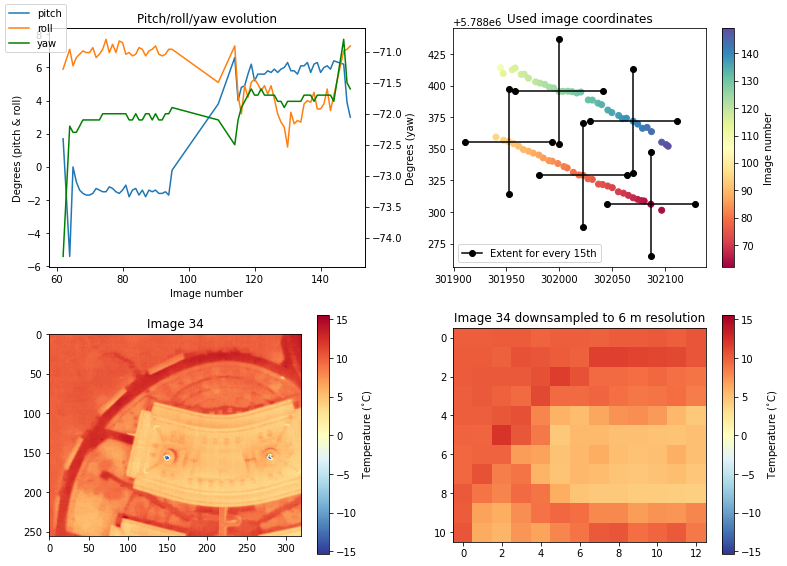

In [11]:
# Apply filters and plot path + example image
# Create dataframe of images associated with flight information
merged = hf.img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType) # Associate path data with images
merged = hf.filter_imgs(merged, filters, filtValues) # Apply data filters
merged, myProj = reproject_coords(merged, utmZone, hemisphere) # Reproject coordinates
idf = hf.correct_coords(merged, 30) # Correct coordinates for ground location (filter out any over n m different)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

## 2 - Auto stitch images using RANSAC algorithm
The first step automatically stitches together images from each line when matching is good enough. If matching is too poor the lines may split into several strips.

In [12]:
# Customisable variable definition - You can edit these to influence the stitching method
start, end, step, skips = 0, len(idf), 1, []  # Filtered images to use (start, end, step, image numbers to skip)
lineDist = height/5  # Distance between images beyond which to split lines
minMatches, std = 4, 22 # Minimum number of matches and maximum standard deviation for a match to be considered correct
max_subs, min_images = 3,2 # Max subsequent images skipped between matches without breaking line
imgPath = 'imgPath' # Name of data column with paths to images
tempfiles = ['temp0.jpg','temp1.jpg'] # Name of temp files to be used
excep, estd = [], 10# np.concatenate([range(214,232),range(240,270)]), 10 # Ranges of image to use different threshold on if initial one comes up with poor matching
verbose = False # Even more verbose matching

# Get the bound temperatures of the images for scaling
tmin, tmax = get_bound_temps(idf,xCoords,yCoords,xq,yq)

# Loop over all images
strips = {} # Initialise
while start < end-1:
    prev, single, prevImg, totalBox, prevBox = st.initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > lineDist:
           break  # Output strip if linedist is above threshold
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]  # Read images

        # Create train and query images
        # for i, arr in enumerate(arrs):
        #     single = ((arr-tmin)*255/tmax).astype(np.uint8)
        #     if i==0: trainImg=np.dstack((single,single,single))
        #     else: queryImg=np.dstack((single,single,single))
        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
            imageio.imwrite(val,np.dstack((single,single,single)))
            
        # Read images - Make sure that the train image is the image that will be transformed
        trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        # Find matches between images and filter 
        ma, mb, _ = st.get_img_translation(trainImg, queryImg)
        mam, mbm, diff = st.filter_img_translation(ma, mb, idf, prev, imgNum)
        totalBox, prevNew, prevImg, prevBox = st.stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, min_matches=minMatches, max_stdev=estd if imgNum in excep else std, verbose=verbose,queryImg=queryImg)
        # Break line if not matched with subsequent n images 
        if prevNew < imgNum-max_subs:
            imgNum = prevNew+1
            break
        else: prev=prevNew

    # Write strip to strips dictionary    
    if start < imgNum+1-min_images: strips.update({start:prevImg})
    start = imgNum

# Create strips directory
if not os.path.isdir('strips/'):
  ! mkdir 'strips'

# Write strips
ks = np.array(list(strips.keys()))
mn = np.median(strips[ks[0]]) # Get mean from first for scaling
for i in ks:
    read = ((strips[i]-np.median(strips[i])+mn)*np.ma.masked_where(strips[i]!=0, strips[i]).mask).astype(np.uint8) # Rescale while keeping 0 values
    imageio.imwrite('strips/'+outName+'_'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))

    #if start<imgNum-1: 
    # result = np.ma.masked_where(prevImg==0, prevImg)
    # conv = np.array(myProj(np.array(sorted([idf.iloc[start].xc, idf.iloc[imgNum].xc]))+[-add, add], np.array(sorted([idf.iloc[start].yc, idf.iloc[imgNum].yc]))+[-add, add], inverse=True))
    # cs, _ = plot_kml(result.data, conv, 'strips_kmz/'+outName+'_'+str(start), 1024*10, rot=rot, temp=False, scale=np.array([13,37]), tmin=tmin, tmax=tmax,cmap=cmap, add_temp=-13, filt=2, hide_plot=True)

# for i in tempfiles: os.remove(i)

Images processed: 68it [00:01, 40.79it/s]
  6%|▌         | 4/67 [00:00<00:03, 18.20it/s]

Raw matches (Brute force): 17
Removed outliers
Images 0 and 1, poor matching
Raw matches (Brute force): 20
Removed outliers
Images 0 and 2 merged.
Raw matches (Brute force): 211
Images 2 and 3 merged.
Raw matches (Brute force): 111
Removed outliers
Images 3 and 4, poor matching
Raw matches (Brute force): 113
Removed outliers
Images 3 and 5, poor matching


 13%|█▎        | 9/67 [00:00<00:03, 18.13it/s]


Raw matches (Brute force): 128
Removed outliers
Images 3 and 6 merged.
Raw matches (Brute force): 133
Removed outliers
Images 6 and 7, poor matching
Raw matches (Brute force): 151
Removed outliers
Images 6 and 8, poor matching
Raw matches (Brute force): 110
Removed outliers
Images 6 and 9, poor matching
Raw matches (Brute force): 140
Removed outliers
Images 6 and 10, poor matching


  5%|▌         | 3/60 [00:00<00:03, 17.08it/s]


Raw matches (Brute force): 147
Removed outliers
Images 7 and 8, poor matching
Raw matches (Brute force): 121
Removed outliers
Images 7 and 9, poor matching
Raw matches (Brute force): 119
Removed outliers
Images 7 and 10, poor matching
Raw matches (Brute force): 125
Removed outliers
Images 7 and 11, poor matching


  0%|          | 0/59 [00:00<?, ?it/s]

Raw matches (Brute force): 106
Removed outliers
Images 8 and 9, poor matching


  5%|▌         | 3/59 [00:00<00:03, 18.29it/s]


Raw matches (Brute force): 115
Removed outliers
Images 8 and 10, poor matching
Raw matches (Brute force): 122
Removed outliers
Images 8 and 11, poor matching
Raw matches (Brute force): 96
Removed outliers
Images 8 and 12, poor matching


  0%|          | 0/58 [00:00<?, ?it/s]

Raw matches (Brute force): 161
Removed outliers
Images 9 and 10, poor matching
Raw matches (Brute force): 119
Removed outliers
Images 9 and 11, poor matching


  5%|▌         | 3/58 [00:00<00:02, 18.49it/s]


Raw matches (Brute force): 98
Removed outliers
Images 9 and 12, poor matching
Raw matches (Brute force): 65
Removed outliers
Images 9 and 13, poor matching


  0%|          | 0/57 [00:00<?, ?it/s]

Raw matches (Brute force): 124
Removed outliers
Images 10 and 11, poor matching
Raw matches (Brute force): 99
Removed outliers
Images 10 and 12, poor matching


  5%|▌         | 3/57 [00:00<00:02, 24.88it/s]

Raw matches (Brute force): 88
Removed outliers
Images 10 and 13, poor matching


  5%|▌         | 3/57 [00:00<00:02, 18.66it/s]


Raw matches (Brute force): 68
Removed outliers
Images 10 and 14, poor matching


  0%|          | 0/56 [00:00<?, ?it/s]

Raw matches (Brute force): 102
Removed outliers
Images 11 and 12, poor matching
Raw matches (Brute force): 83
Removed outliers
Images 11 and 13, poor matching


  5%|▌         | 3/56 [00:00<00:02, 25.91it/s]

Raw matches (Brute force): 86
Removed outliers
Images 11 and 14, poor matching


  5%|▌         | 3/56 [00:00<00:02, 20.16it/s]


Raw matches (Brute force): 59
Removed outliers
Images 11 and 15, poor matching


  0%|          | 0/55 [00:00<?, ?it/s]

Raw matches (Brute force): 79
Removed outliers
Images 12 and 13, poor matching


  5%|▌         | 3/55 [00:00<00:01, 27.88it/s]

Raw matches (Brute force): 69
Removed outliers
Images 12 and 14, poor matching
Raw matches (Brute force): 55
Removed outliers
Images 12 and 15, poor matching


  5%|▌         | 3/55 [00:00<00:02, 20.23it/s]


Raw matches (Brute force): 28
Removed outliers
Images 12 and 16, poor matching


  0%|          | 0/54 [00:00<?, ?it/s]

Raw matches (Brute force): 76
Removed outliers
Images 13 and 14, poor matching
Raw matches (Brute force): 47
Removed outliers
Images 13 and 15, poor matching
Raw matches (Brute force): 23
Removed outliers
Images 13 and 16, poor matching


  6%|▌         | 3/54 [00:00<00:02, 24.40it/s]


Raw matches (Brute force): 22
Removed outliers
Images 13 and 17, poor matching


  0%|          | 0/53 [00:00<?, ?it/s]

Raw matches (Brute force): 45
Removed outliers
Images 14 and 15, poor matching
Raw matches (Brute force): 22
Removed outliers
Images 14 and 16, poor matching
Raw matches (Brute force): 22
Removed outliers
Images 14 and 17, poor matching


  6%|▌         | 3/53 [00:00<00:02, 24.11it/s]


Raw matches (Brute force): 22
Removed outliers
Images 14 and 18, poor matching


  0%|          | 0/52 [00:00<?, ?it/s]

Raw matches (Brute force): 28
Images 15 and 16 merged.
Raw matches (Brute force): 35
Images 16 and 17 merged.
Raw matches (Brute force): 35
Images 17 and 18 merged.


  8%|▊         | 4/52 [00:00<00:01, 37.95it/s]

Raw matches (Brute force): 48
Images 18 and 19 merged.
Raw matches (Brute force): 60
Images 19 and 20 merged.
Raw matches (Brute force): 46
Images 20 and 21 merged.
Raw matches (Brute force): 33


 15%|█▌        | 8/52 [00:00<00:01, 35.59it/s]

Images 21 and 22 merged.
Raw matches (Brute force): 85
Images 22 and 23 merged.
Raw matches (Brute force): 81
Images 23 and 24 merged.
Raw matches (Brute force): 107
Removed outliers
Images 24 and 25 merged.
Raw matches (Brute force): 109
Removed outliers
Images 25 and 26 merged.


 23%|██▎       | 12/52 [00:00<00:01, 31.69it/s]

Raw matches (Brute force): 126
Images 26 and 27 merged.
Raw matches (Brute force): 111
Images 27 and 28 merged.
Raw matches (Brute force): 103
Images 28 and 29 merged.
Raw matches (Brute force): 89


 33%|███▎      | 17/52 [00:00<00:01, 32.17it/s]

Removed outliers
Images 29 and 30 merged.
Raw matches (Brute force): 83
Removed outliers
Images 30 and 31 merged.
Raw matches (Brute force): 82
Images 31 and 32 merged.



  0%|          | 0/34 [00:00<?, ?it/s]

Raw matches (Brute force): 18
Removed outliers
Images 33 and 34 merged.
Raw matches (Brute force): 34
Images 34 and 35, poor matching


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
 12%|█▏        | 4/34 [00:00<00:00, 38.00it/s]

Raw matches (Brute force): 28
Images 34 and 36, poor matching
Raw matches (Brute force): 7
Images 34 and 37, poor matching


 12%|█▏        | 4/34 [00:00<00:01, 29.12it/s]


Raw matches (Brute force): 18
Images 34 and 38, poor matching


  0%|          | 0/32 [00:00<?, ?it/s]

Raw matches (Brute force): 38
Images 35 and 36, poor matching
Raw matches (Brute force): 10
Images 35 and 37, poor matching


  9%|▉         | 3/32 [00:00<00:01, 27.26it/s]


Raw matches (Brute force): 19
Removed outliers
Images 35 and 38, poor matching
Raw matches (Brute force): 19
Images 35 and 39, poor matching


  0%|          | 0/31 [00:00<?, ?it/s]

Raw matches (Brute force): 6
Images 36 and 37, poor matching
Raw matches (Brute force): 20
Images 36 and 38, poor matching


 10%|▉         | 3/31 [00:00<00:00, 31.40it/s]

Raw matches (Brute force): 22
Images 36 and 39, poor matching
Raw matches (Brute force): 27
Images 36 and 40, poor matching



  0%|          | 0/30 [00:00<?, ?it/s]

Raw matches (Brute force): 6
Images 37 and 38, poor matching


 10%|█         | 3/30 [00:00<00:00, 30.83it/s]


Raw matches (Brute force): 8
Images 37 and 39, poor matching
Raw matches (Brute force): 8
Images 37 and 40, poor matching
Raw matches (Brute force): 7
Images 37 and 41, poor matching


  0%|          | 0/29 [00:00<?, ?it/s]

Raw matches (Brute force): 17
Removed outliers
Images 38 and 39 merged.


 14%|█▍        | 4/29 [00:00<00:00, 36.90it/s]

Raw matches (Brute force): 26
Images 39 and 40 merged.
Raw matches (Brute force): 35
Images 40 and 41 merged.
Raw matches (Brute force): 12
Removed outliers
Images 41 and 42, poor matching
Raw matches (Brute force): 11
Removed outliers
Images 41 and 43, poor matching


 28%|██▊       | 8/29 [00:00<00:00, 36.68it/s]

Raw matches (Brute force): 23
Images 41 and 44 merged.
Raw matches (Brute force): 19
Images 44 and 45 merged.
Raw matches (Brute force): 26
Images 45 and 46 merged.
Raw matches (Brute force): 31
Images 46 and 47 merged.
Raw matches (Brute force): 43
Images 47 and 48 merged.
Raw matches (Brute force): 44
Images 48 and 49 merged.
Raw matches (Brute force): 53


 41%|████▏     | 12/29 [00:00<00:00, 35.01it/s]

Images 49 and 50 merged.
Raw matches (Brute force): 49
Images 50 and 51 merged.
Raw matches (Brute force): 57
Images 51 and 52 merged.
Raw matches (Brute force): 71
Images 52 and 53 merged.


 55%|█████▌    | 16/29 [00:00<00:00, 32.71it/s]

Raw matches (Brute force): 72
Images 53 and 54 merged.
Raw matches (Brute force): 63
Images 54 and 55 merged.
Raw matches (Brute force): 64
Images 55 and 56 merged.
Raw matches (Brute force): 67
Images 56 and 57 merged.


 69%|██████▉   | 20/29 [00:00<00:00, 32.71it/s]

Raw matches (Brute force): 83
Images 57 and 58 merged.
Raw matches (Brute force): 81
Images 58 and 59 merged.
Raw matches (Brute force): 67
Images 59 and 60 merged.
Raw matches (Brute force): 66
Images 60 and 61 merged.


 83%|████████▎ | 24/29 [00:00<00:00, 31.15it/s]

Raw matches (Brute force): 52
Images 61 and 62 merged.
Raw matches (Brute force): 59
Images 62 and 63 merged.


100%|██████████| 29/29 [00:00<00:00, 32.52it/s]

Raw matches (Brute force): 45
Images 63 and 64 merged.
Raw matches (Brute force): 29
Images 64 and 65 merged.
Raw matches (Brute force): 27
Images 65 and 66 merged.
Raw matches (Brute force): 28
Images 66 and 67 merged.


68 images combined into 4 strips.


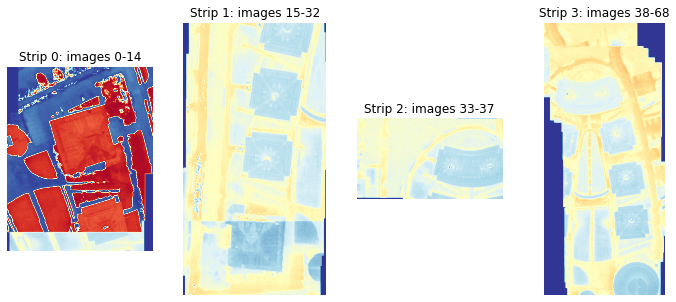

In [18]:
# Run this cell to visualise strips
cols = min(len(ks),7)
print(str(len(idf))+' images combined into '+str(ks.shape[0])+' strips.')
fig, axs = plt.subplots(int(np.ceil(ks.shape[0]/cols)),cols,figsize=[cols*3,5*int(np.ceil(ks.shape[0]/cols))])
for i in range(len(ks)):
  ax = axs[int(np.floor(i/cols)),i%cols] if len(ks)>cols else axs[i%cols]
  ax.imshow(imageio.imread('strips/'+outName+'_'+str(ks[i])+'.jpg')[:,:,0],cmap='RdYlBu_r')
  ax.axis('off')
  if i+1 < len(ks):
    ax.set_title('Strip '+str(i)+': images '+str(ks[i])+'-'+str(ks[i+1]-1))
  else: 
    ax.set_title('Strip '+str(i)+': images '+str(ks[i])+'-'+str(len(idf)))
    break

####b - Manually assign matches between strips
In this step we now manually assign matching points to stitch lines together. The auto matches are displayed for guidance but are generally incorrect. Manual assignment either defines a margins box around a set of correct auto matches, or we can assign specific matching x,y points between the two images

In [68]:
# Initialise
feature_extractor, feature_matching, verbose, max_disp = 'orb', 'bf', False, 5
n = 1
rot = 0
i, firstMerge = ks[n], False
# For restarting from image
#i, firstMerge = 'p'+str(n-1)+'_'+str(n), True

<a name='run_strip'></a>
Re-run following cell until all strips have been compared

In [73]:
margins = False
print('Strip: '+str(n+1)+'/'+str(ks.shape[0]))
if firstMerge is False: i = ks[n]
j, k = ks[2], 'p'+str(n)+'_'+str(n+1)
#j, k = ks[n+1], 'p'+str(n)+'_'+str(n+1)
tempfiles = ['strips/'+outName+'_'+str(num)+'.jpg' for num in [i,j]]

arrs = [img_to_arr(tempfiles[0], xq=xq, yq=yq), img_to_arr(tempfiles[1], xq=xq, yq=yq)]
trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
queryImg = np.ma.masked_where(ndimage.rotate(queryImg, rot)<1e-2, ndimage.rotate(queryImg, rot))

trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)

matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0] and kpsA[i.queryIdx].pt[0] < margins[1] and kpsA[i.queryIdx].pt[1] > margins[2]
                                     and kpsA[i.queryIdx].pt[1] < margins[3] for i in matches])) if margins is not False else matches

img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,max_disp),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

togs = ipw.Box([ipw.Label(value='Merge '), ipw.Checkbox(value=True, disabled=False, indent=False), ipw.Label(value='Old on top '), ipw.Checkbox(value=True, disabled=False, indent=False)])
vals1 = ipw.Box([ipw.Label(value='Image 1 - x: '), ipw.IntText(value=200, placeholder='pxs',  disabled=False), ipw.Label(value=' y: '), ipw.IntText(value=200, placeholder='pxs',  disabled=False)])
vals2 = ipw.Box([ipw.Label(value='Image 2 - x: '), ipw.IntText(value=500, placeholder='pxs',  disabled=False), ipw.Label(value=' y: '), ipw.IntText(value=200, placeholder='pxs',  disabled=False)])
display(togs,vals1,vals2)

fig = px.imshow(img3[:,:,0], width=img3.shape[1], height=img3.shape[0], color_continuous_scale='rdylbu_r')
fig.layout.coloraxis.showscale = False
fig.update_layout(dragmode='drawline', newshape_line_color='cyan',margin=dict(l=0,r=0,b=0,t=0))
fig.show()
newStrip = True

Strip: 4/4
Raw matches (Brute force): 31


Box(children=(Label(value='Merge '), Checkbox(value=True, indent=False), Label(value='Old on top '), Checkbox(…

Box(children=(Label(value='Image 1 - x: '), IntText(value=200), Label(value=' y: '), IntText(value=200)))

Box(children=(Label(value='Image 2 - x: '), IntText(value=500), Label(value=' y: '), IntText(value=200)))

Filt. matches: 1, stdev: 0.0
[100, 360, 0, 467]
Images 0 and 1 merged.


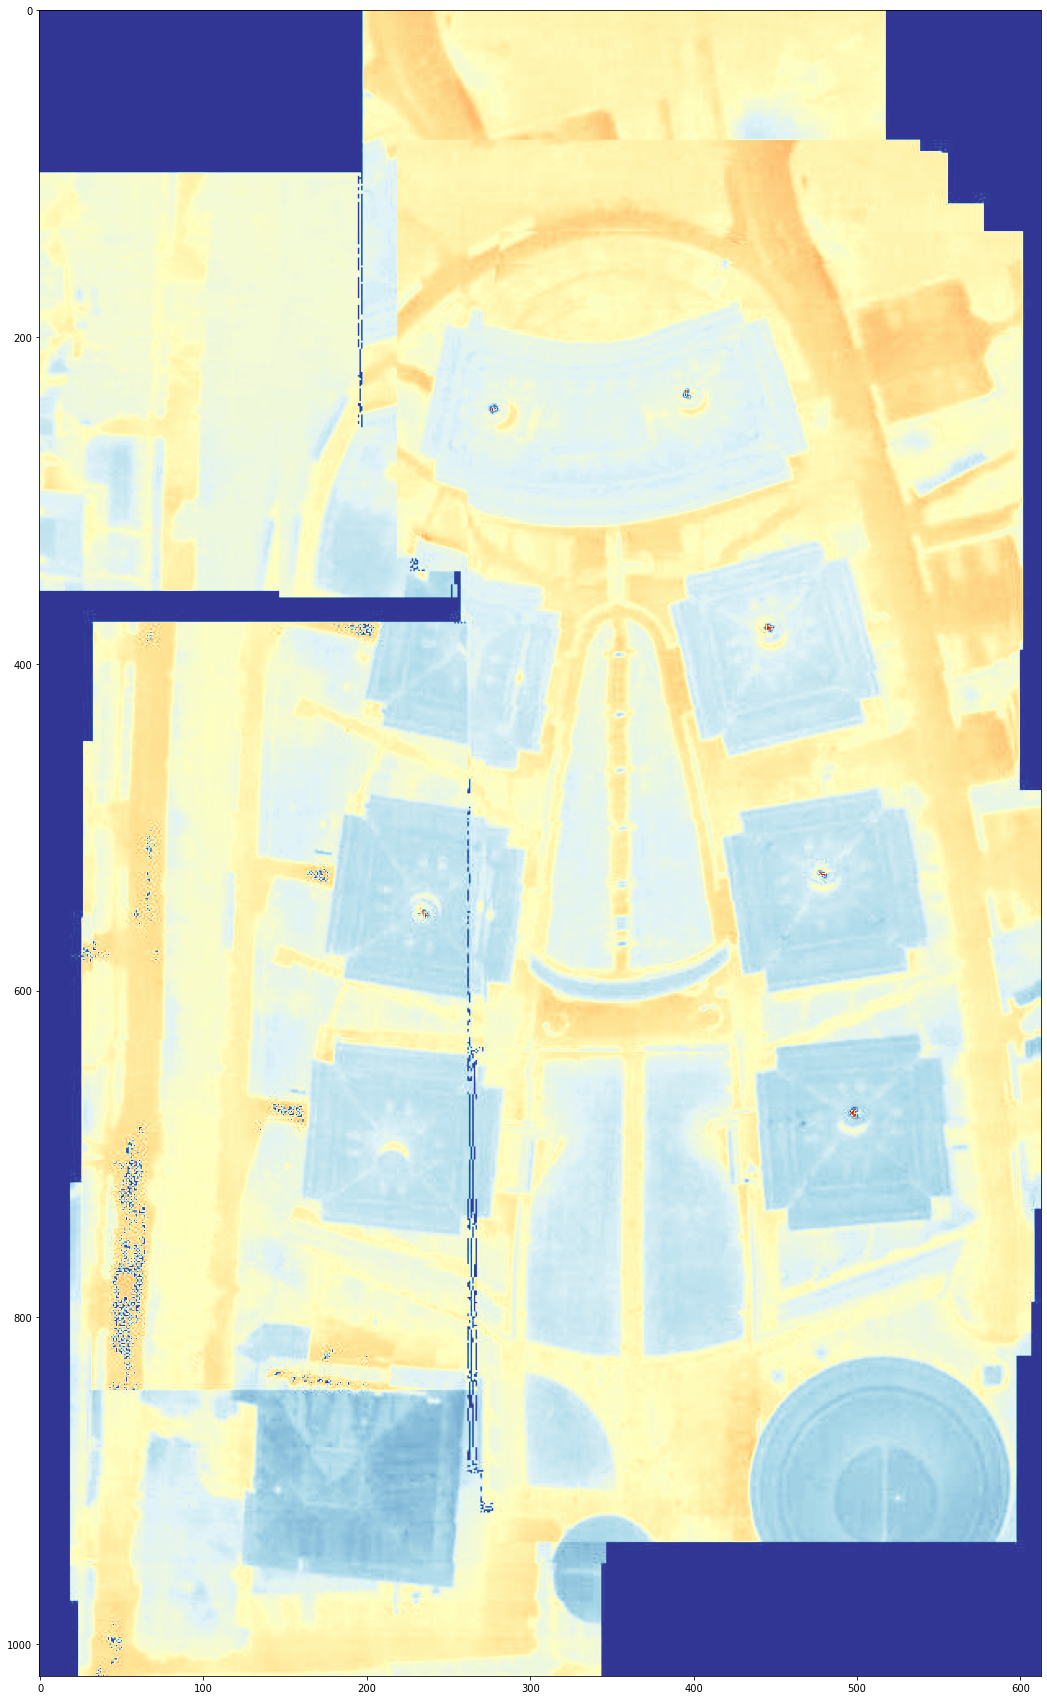

In [76]:
#firstMerge=True
merge = togs.children[1].value
old_on_top = togs.children[3].value
x_left, y_left = vals1.children[1].value, vals1.children[3].value
x_right, y_right = vals2.children[1].value, vals2.children[3].value

if merge and newStrip:
  diff, ma, mb = [x_left-x_right+trainImg.shape[1], y_left-y_right], np.array([1]), np.array([1])

  totalBox=[trainImg.shape[0], trainImg.shape[1]]
  prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
  prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

  totalBox, prevNew, prevImg, prevBox = stitch_img_result_pano(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum=0, imgNum=1,
                      min_matches=0, max_stdev=10000, tmin=tmin, tmax=tmax, verbose=True, rgb_query=queryImg, inv=old_on_top)

  single = prevImg.mean(axis=2).astype(np.uint8)
  imageio.imwrite('strips/'+outName+'_'+k+'.jpg',np.dstack((single,single,single)))
  fig, ax = plt.subplots(figsize=(single.shape[0]/20, single.shape[1]/20))
  ax.imshow(single, cmap=cmap)
  plt.show()  
  i, firstMerge = k, True
elif firstMerge is False: i=ks[n+1]
n += 1
newStrip = False 

[Next step](#run_strip)

In [75]:
newStrip = True
n-=1

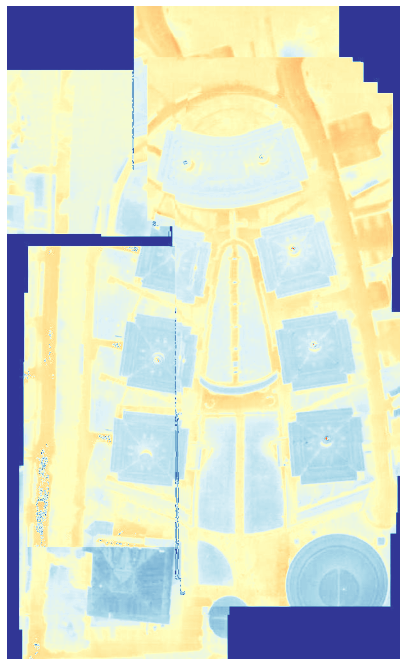

In [79]:
  fig, ax = plt.subplots(figsize=(12, 12))
  ax.imshow(single, cmap=cmap)
  plt.axis('off')
  plt.show()  

####c - Save as Google Earth .kml

In [80]:
tmin, tmax = get_bound_temps(idf,xCoords,yCoords,xq,yq)

Images processed: 68it [00:01, 43.52it/s]


In [82]:
# # Legend + flight path
# conv = np.array(myProj([idf.xc.min()-add, idf.xc.max()+add], [idf.yc.min()-add, idf.yc.max()+add], inverse=True))
# pl.plot_kml_legend(cs, outName+'_stitchlegend')
# pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)

# # Create kml
# pl.make_kml(conv, figs=['strips_kmz/'+outName+'_'+str(i)+'.png' for i in ks], 
#             colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_pieces.kmz',
#             description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

# Save as .kmz file
image = np.array(imageio.imread('/content/s4-thermal/strips/CMS_p3_4.jpg')) # np.dstack((single,single,single))
result = np.ma.masked_where(image==0, image)
extent = [] # Auto get coords from idf
inputCoords = np.array([[0.089216, 0.093611],[52.241702, 52.244020]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, first = plot_kml(result.data, conv, outName+'_stitch_hr', 1536*10, rot=0, temp=False, tmin=tmin, tmax=tmax,cmap=cmap, filt=2)
#_, ds = pl.plot_kml(hf.downsample_arr(first,pxSize,resolution), conv, outName+'_ds_stitch', 1024*10, rot=0, scale=first, cmap=cmap)
# 90+idf['yaw(deg)'].mean()+19

/content/s4-thermal/plotting.py:138: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



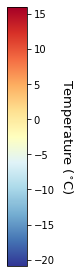

In [83]:
pl.plot_kml_legend(cs, outName+'_stitchlegend')
#pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)
pl.make_kml(conv, figs=[outName+'_stitch_hr.png'], 
            colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_thermal_hr.kmz',
            description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

In [ ]:
save_to_csv(first, ds, conv, pxSize, resolution, outName+'_stitch', single=True)

## Other - Merge according to xy coordinates

In [ ]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

In [ ]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, single = pl.plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90, cmap=cmap)
_, ds = pl.plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid, cmap=cmap)
pl.plot_kml_legend(cs, outName+'_xylegend')
pl.plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [ ]:
pl.save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

In [5]:
def reproject_coords(df, utmZone, hemisphere='north', inverse=False, 
                     orig=['longitude','latitude'], local=['x','y']):
    """Reprojects coordinates in dataframe to new column
    
    Input:
    df - Dataframe containg coordinates
    utmZone - WGS84 UTM zone
    hemisphere - north or south
    inverse - False for lat/lon to local, True for local to lat/lon
    
    Output:
    df - Dataframe with new column for coordinates
    """
    # Convert coordinates to UTM
    myProj = Proj(proj='utm', zone=utmZone, ellps='WGS84', preserve_units=False)
    if inverse: df[orig[0]], df[orig[1]] = myProj(df[local[0]].values, df[local[1]].values, inverse=True)
    else: df[local[0]], df[local[1]] = myProj(df[orig[0]].values, df[orig[1]].values)
    return df, myProj

In [6]:
def img_to_arr(filepath, xq=False, yq=False):
    if '.npy' in filepath: 
        arr = np.load(filepath)
        if xq and yq: arr = arr[yq:arr.shape[0]-yq,xq:arr.shape[1]-xq]
    else:
        img = imageio.imread(filepath)
        #img = ro.open(filepath)
        read = img[:, yq:img.shape[0]-yq,xq:img.shape[1]-xq] if xq and yq else img
        arr = np.dstack((read[0],read[1],read[2]))/255  
    return arr

In [7]:
def get_bound_temps(df, xCoords, yCoords, xq, yq, skip=1, imageType=False, coords = ['yc','xc'], totmin=-10, totmax=40):
    """Function loops over images to get xy grid of data points
    Input:
    df - dataframe with flight information
    xq, yq - image coordinate delimiters
    xCoords, yCoords - Coordinates relative to centre of each image for all pixels
    pxSize - pixel size of images
    skip - Use every nth image
    imageType - True if RGB image, False if numpy array type (converted thermal images)
    coords - name of coordinate columns to use from df
    method - interpolation method (nearest, linear, cubic)
    
    Output:
    xygrid - array of data values for each point on xy grid
    extent - Boundary coordinates for xy grid
    """
    xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq]) if xq is not False else np.meshgrid(xCoords,yCoords)
    xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

    alltot = [0,0,0,0,0] if imageType else [0,0,0]
    for index, row in tqdm(df[::skip].iterrows(), desc='Images processed'):
        imgst = hf.img_to_arr(row.imgPath, xq, yq)
        total = np.concatenate((xmcr+row[coords[0]], ymcr+row[coords[1]], imgst.reshape(-1,1) if len(imgst.shape) == 2 else [imgst[:,:,i].reshape(-1,1) for i in range(len(imgst.shape))]),axis=-1)
        alltot = np.vstack((alltot,total))
    return int(np.floor(alltot[1:,2].min())), int(np.ceil(alltot[1:,2].max()))

In [48]:
def stitch_img_result_pano(mam, mbm, diff, totalBox, prevBox, img_arrs, prevImg, prevNum, imgNum,
                           min_matches=4, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=False,inv=False):
    if verbose: print('Filt. matches: '+str(len(mam))+', stdev: ' + str(round(np.std(mam-mbm, axis=0).mean(),2)))
    # Filter for conditions
    if len(mam) > min_matches and np.std(mam-mbm, axis=0).mean() < max_stdev:
        # New box position before adjustment for expanding total box
        if rgb_query is not False:
            newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[0]+diff[1]))+rgb_query.shape[0], int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[2]+diff[0]))+rgb_query.shape[1]] 
        else: newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] 
        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        # If bounds on axis 0 go beyond total
        if newBox[0]<0 and newBox[1] > totalBox[0]:
            xmin, xmax = imgNum, imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]=newBox[1]-min(newBox[0],0)
        elif newBox[0]<0:
            xmin = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]+=abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax = imgNum
            modBox[1], modBox[0] = newBox[1], newBox[0]
            totalBox[0]=newBox[1]
        else: modBox[0], modBox[1] = newBox[0], newBox[1] #newBox[0]>0 and newBox[1] < totalBox[0]:
                 
        # If bounds on axis 1 go beyond total
        if newBox[2]<0 and newBox[3] > totalBox[1]:
            ymin, ymax = imgNum, imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]=newBox[3]-min(newBox[2],0)
        elif newBox[2]<0:
            ymin = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]+=abs(newBox[2])
        elif newBox[3] > totalBox[1]:
            ymax = imgNum
            modBox[3], modBox[2] = newBox[3], newBox[2]
            totalBox[1] = newBox[3] #-min(newBox[2],0)
        else: modBox[2], modBox[3] = newBox[2], newBox[3]
        prevBox = modBox 
        print(modBox)
        
        if len(img_arrs[1].shape) == 2:
            single = (img_arrs[1]-tmin)*255/tmax
            queryImg = np.dstack((single,single,single)).astype(np.uint8)
        else: queryImg = rgb_query
        result = np.zeros([totalBox[0],totalBox[1],3])
        if inv:
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
            prevImg.data[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:] += np.array(queryImg[max(0,-newBox[0]):min(queryImg.shape[0],prevImg.shape[0]-max(newBox[0],0)), max(0,-newBox[2]):min(queryImg.shape[1],prevImg.shape[1]+max(-newBox[2],0)),:]*(prevImg.mask[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:]))
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg   
        else:    
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
            print(-min(newBox[0],0),min(queryImg.shape[0],prevImg.shape[0]-newBox[0]), -min(newBox[2],0),min(queryImg.shape[1],prevImg.shape[1]-newBox[2]))
            queryImg.data[-min(newBox[0],0):min(queryImg.shape[0],prevImg.shape[0]-newBox[0]), -min(newBox[2],0):min(queryImg.shape[1],prevImg.shape[1]-newBox[2])] += np.array(prevImg[max(0,newBox[0]):min(prevImg.shape[0],newBox[1]), max(0,newBox[2]):min(prevImg.shape[1],newBox[3]),:]*(queryImg.mask[-min(newBox[0],0):min(queryImg.shape[0],prevImg.shape[0]-newBox[0]), -min(newBox[2],0):min(queryImg.shape[1],prevImg.shape[1]-newBox[2])]))
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prevNum),str(imgNum)))
        prevNum, prevImg = imgNum, result
    else: print('Images {} and {}, poor matching'.format(str(prevNum),str(imgNum)))
    return totalBox, prevNum, prevImg, prevBox

In [9]:
# Save as .csv file
def save_to_csv(arr1, arr2, conv, res1, res2, name, single=False):
    arr_s = arr1.shape
    ptslon = np.linspace(conv[0].min(),conv[0].max(),arr_s[1]+1)[:-1]
    ptslon += (ptslon[1]-ptslon[0])/2
    ptslat = np.linspace(conv[1].min(),conv[1].max(),arr_s[0]+1)[:-1]
    ptslat += (ptslat[1]-ptslat[0])/2
    lonm, latm = np.meshgrid(ptslon,ptslat)
    if single: tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)'])
    else:
        ds_q = int(np.floor(res1/res2))
        if ds_q>1:
            arr_mod = np.round(arr2[:-(arr2.shape[0] % ds_q),:-(arr2.shape[1] % ds_q)]).astype(int)
            most=np.zeros([len(range(0,arr_mod.shape[0]-ds_q,ds_q))+1, len(range(0,arr_mod.shape[1]-ds_q,ds_q))+1])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    most[int(i/ds_q),int(j/ds_q)] = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        else:
            ds_q = int(np.floor(res2/res1))
            arr_mod = np.round(arr1[:-(arr1.shape[0] % ds_q),:-(arr1.shape[1] % ds_q)]).astype(int)
            most=np.zeros([arr1.shape[0], arr1.shape[1]])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    #print(Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0])
                    ct = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
                    most[int(i/ds_q):int(i/ds_q)+ds_q,int(j/ds_q):int(j/ds_q)+ds_q] = np.array([[ct for y in range(ds_q)] for x in range(ds_q)]) if ct is None else np.array([[ct for y in range(ds_q)] for x in range(ds_q)]).astype(int)

        tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)', str(round(res2, 2))+'m T(C)'])
    filt = tdf[arr1.mask.reshape(-1,1) == False]
    filt.to_csv(name+'.csv', index_label='UID')

In [10]:
def plot_kml(arr, conv, name, pixels, rot=False, scale=False, temp=True, tmin=0, tmax=40,cmap='hot', add_temp=0, filt=1, hide_plot=False):
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                            urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                            pixels=pixels, hide_plot=hide_plot)
    if len(arr.shape) > 2: arr = arr.mean(axis=2)
    if rot is not False: arr = np.ma.masked_where(ndimage.rotate(arr, rot)<(1e-2), ndimage.rotate(arr, rot))
    single = arr if temp else np.ma.masked_where(arr/255*tmax+tmin < tmin+filt, arr/255*tmax+tmin)
    if scale is False: scale = single+add_temp
    cs = ax.imshow(single+add_temp,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=scale.min(),vmax=scale.max())
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)
    if hide_plot: plt.close(fig)
    return cs, single